# Heartbeat Classification using LSTM

#### Importing necessay libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import expand_dims
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Flatten, Dense, Conv1D, Activation
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/sample_data/mnist_train_small.csv')
print(df.shape)

(19999, 785)


In [ ]:
# Assuming your CSV files are in a directory named 'data'
data_dir = 'data'

First we will tackle the binary classification (normal and abnormal) problem with PTB dataset.
Later we will deal with multi-class (five categories) classification problem with MIT-BIH dataset.

## Binary Classification of Normal and Abnormal Heartbeat from PTB data
#### Reading PTB files for binary classification

In [ ]:
df_list = [pd.read_csv('/content/sample_data/mnist_train_small.csv') for i in ['abnormal','normal']]
for i,df in enumerate(df_list):
    df.columns = list(range(len(df.columns)))
    df_list[i] = df.rename({187:'Label'}, axis=1)

In [ ]:
# Abnormal
df_list[0].head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Normal
df_list[1].head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Let's concat them
df = pd.concat(df_list, axis=0).reset_index(drop=True)
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39994,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39996,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y = df['Label']
y

,Label
0,236
1,97
2,0
3,123
4,196
...,...
39993,44
39994,0
39995,253
39996,255


In [ ]:
X = df.drop('Label', axis=1)
X

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39994,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39996,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Visualization

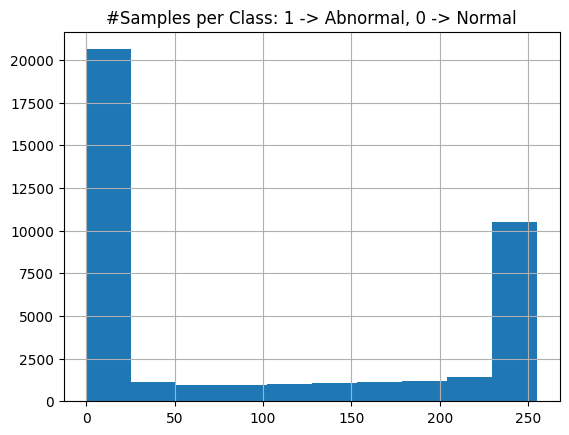

In [ ]:
y.hist()
plt.title('#Samples per Class: 1 -> Abnormal, 0 -> Normal')
plt.show()

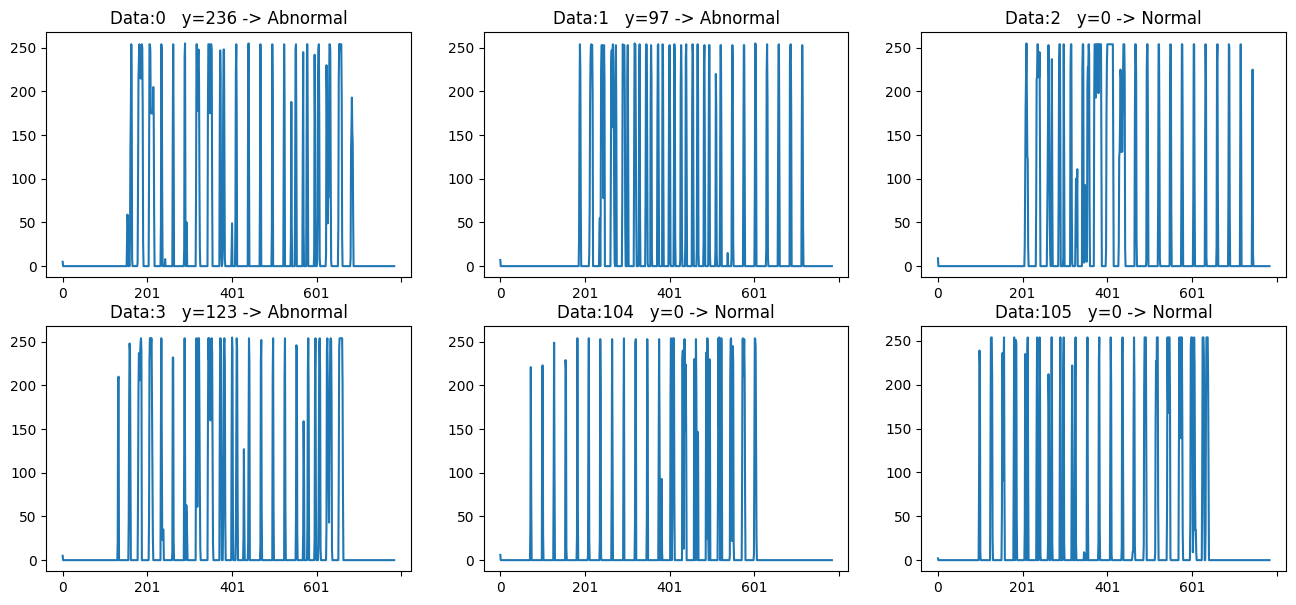

In [ ]:
import matplotlib.pyplot as plt

n = 6
plt.figure(figsize=(16,7))
s = 0
for i in range(n):
    if i > 3:
        s = 100
    plt.subplot(200 + (n * 5) + i + 1)

    if s + i < len(X):
        X.iloc[s + i].plot()
        t = 'Normal'
        if y.iloc[s + i]:
            t = 'Abnormal'
        plt.title(f'Data:{s + i}   y={y.iloc[s + i]} -> {t}')
    else:
        print(f"Warning: Skipping index {s + i} as it's out of bounds.")

plt.show()

236


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7939: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


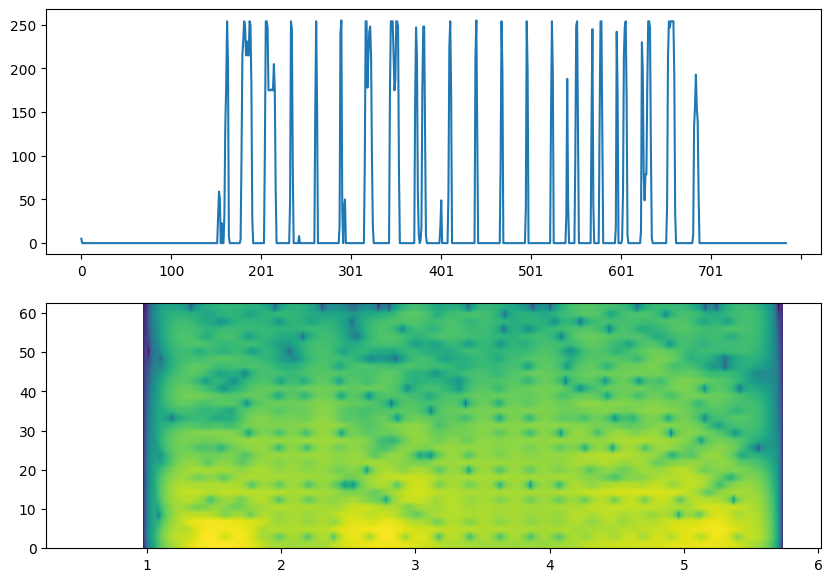

In [ ]:
# Spectrogram visualization
i=0
print(y[i])
data = X.iloc[i]
NFFT = 64
Fs = 125
plt.figure(figsize=(10,7))
ax1 = plt.subplot(211)
data.plot()
plt.subplot(212)
Pxx, freqs, bins, im = plt.specgram(data, NFFT=NFFT,   Fs=Fs,noverlap=63) #, cmap=plt.cm.gist_heat)
plt.show()

In [ ]:
Pxx.shape

(33, 721)

In [ ]:
Pxx

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

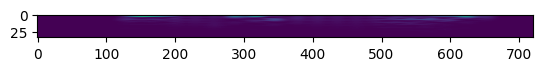

In [ ]:
plt.imshow(Pxx)

In [ ]:
freqs, bins

(array([ 0.      ,  1.953125,  3.90625 ,  5.859375,  7.8125  ,  9.765625,
        11.71875 , 13.671875, 15.625   , 17.578125, 19.53125 , 21.484375,
        23.4375  , 25.390625, 27.34375 , 29.296875, 31.25    , 33.203125,
        35.15625 , 37.109375, 39.0625  , 41.015625, 42.96875 , 44.921875,
        46.875   , 48.828125, 50.78125 , 52.734375, 54.6875  , 56.640625,
        58.59375 , 60.546875, 62.5     ]),
 array([0.256, 0.264, 0.272, 0.28 , 0.288, 0.296, 0.304, 0.312, 0.32 ,
        0.328, 0.336, 0.344, 0.352, 0.36 , 0.368, 0.376, 0.384, 0.392,
        0.4  , 0.408, 0.416, 0.424, 0.432, 0.44 , 0.448, 0.456, 0.464,
        0.472, 0.48 , 0.488, 0.496, 0.504, 0.512, 0.52 , 0.528, 0.536,
        0.544, 0.552, 0.56 , 0.568, 0.576, 0.584, 0.592, 0.6  , 0.608,
        0.616, 0.624, 0.632, 0.64 , 0.648, 0.656, 0.664, 0.672, 0.68 ,
        0.688, 0.696, 0.704, 0.712, 0.72 , 0.728, 0.736, 0.744, 0.752,
        0.76 , 0.768, 0.776, 0.784, 0.792, 0.8  , 0.808, 0.816, 0.824,
        0.832, 0.84

236


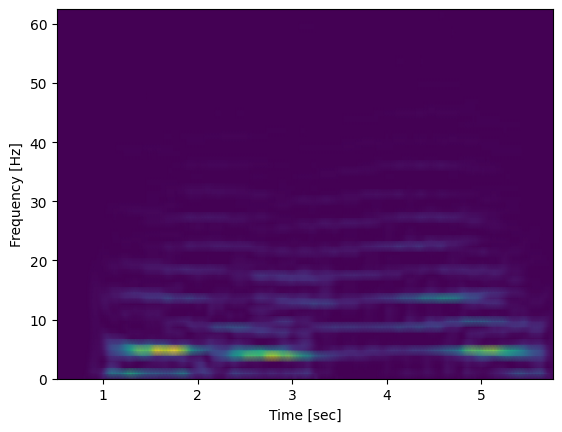

In [ ]:
from scipy import signal
# Scipy spectrogram
# i=0
print(y[i])
data = X.iloc[i]
NFFT = 128
Fs = 125
f, t, Sxx = signal.spectrogram(data, nperseg=NFFT, nfft=NFFT, fs=Fs, noverlap=127) #, cmap=plt.cm.gist_heat)

plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
Sxx

array([[1.41782407e-03, 0.00000000e+00, 0.00000000e+00, ...,
        8.51841972e+01, 6.14433031e+01, 3.88575922e+01],
       [5.33708680e-05, 0.00000000e+00, 0.00000000e+00, ...,
        1.48606352e+02, 1.37465242e+02, 1.30150445e+02],
       [4.16960574e-05, 0.00000000e+00, 0.00000000e+00, ...,
        4.03249276e+01, 5.16035385e+01, 6.19726775e+01],
       ...,
       [1.28973814e-14, 0.00000000e+00, 0.00000000e+00, ...,
        1.01829387e+00, 1.05329407e+00, 1.08521710e+00],
       [1.60436144e-15, 0.00000000e+00, 0.00000000e+00, ...,
        1.28091757e+00, 1.23762270e+00, 1.20071132e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.08029816e-01, 6.66135702e-01, 6.30588160e-01]])

### Get specgram pxx for all X's

In [ ]:
def get_specgram(data):
    NFFT = 64
    Fs = 125
    pxx, freqs, bins, im = plt.specgram(data, NFFT=NFFT, Fs=Fs, noverlap=63) #, cmap=plt.cm.gist_heat)
    return pxx

In [ ]:
from scipy import signal
def get_spectrogram(data):
    NFFT = 128
    Fs = 125
    f, t, Sxx = signal.spectrogram(data, nperseg=NFFT, nfft=NFFT, fs=Fs, noverlap=127) #, cmap=plt.cm.gist_heat)
    return Sxx


In [ ]:
%%time
X_sxx = X.apply(lambda row : get_spectrogram(row), axis=1)

In [ ]:
plt.imshow(X_sxx[0])

In [ ]:
Sxx

In [ ]:
X_sxx[0]

In [ ]:
X_sxx.shape

In [ ]:
X_sxx = np.array(list(X_sxx))

In [ ]:
X_sxx.shape

(12142, 65, 60)

In [ ]:
X_sxx = np.moveaxis(X_sxx, 1, -1)

In [ ]:
X_sxx.shape

(12142, 60, 65)

### Train-Test Split

In [ ]:
# Using only time domain data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Model

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8499, 187), (3643, 187), (8499,), (3643,))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, LSTM, Flatten, Dense, Reshape
from tensorflow.keras.models import Model

inputs = Input(shape=(X_train.shape[1],))
expand = Reshape((X_train.shape[1], 1))(inputs)
conv1 = Conv1D(filters=128,kernel_size=5,strides=1)(expand)
conv1 = Activation("relu")(conv1)
conv2 = Conv1D(filters=256,kernel_size=5,strides=2)(conv1)
conv2 = Activation("relu")(conv2)
lstm = LSTM(100,return_sequences=True)(conv2)
lstm = LSTM(100,return_sequences=True)(lstm)
flatten = Flatten()(lstm)
outputs = Dense(1, activation='sigmoid')(flatten)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 187)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 183, 128)            │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 183, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 90, 256)             │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 90, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 90, 100)             │         142,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 90, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           9,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 397,065 (1.51 MB)

 Trainable params: 397,065 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',AUC(name='auc')])

In [ ]:
callbacks_list = [EarlyStopping(monitor='val_loss',
                                patience=20,
                                restore_best_weights=True)]

In [ ]:
model_history = model.fit(X_train,
                          y_train,
                          validation_split=0.2,
                          batch_size=128,
                          epochs=100,
                          callbacks=callbacks_list)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.1169 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.1018 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 919ms/step - accuracy: 0.1208 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.1018 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 921ms/step - accuracy: 0.1194 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.1018 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 948ms/step - accuracy: 0.1209 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.1018 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 925ms/step - accuracy: 0.1211 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.1018 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 909ms/step - accuracy: 0.1171 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.1018 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 7/100
54/54 ━

In [ ]:
model_history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss'])

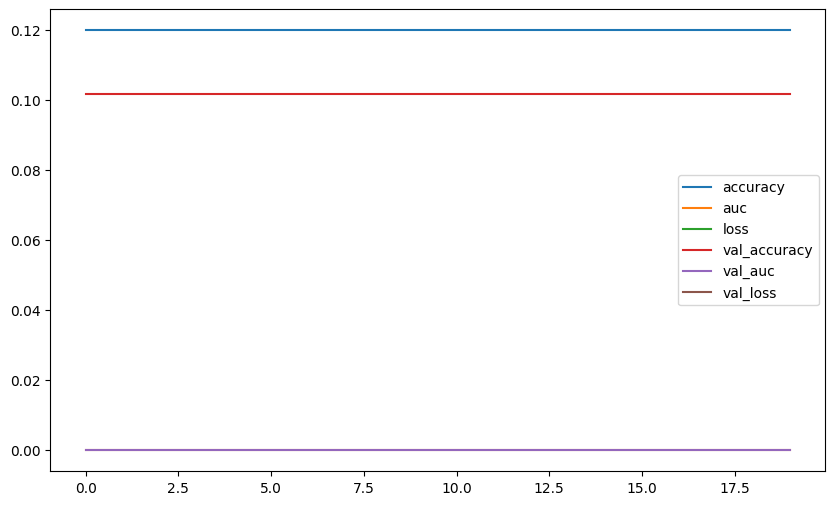

In [ ]:
plt.figure(figsize=[10,6])
for key in model_history.history.keys():
    plt.plot(model_history.history[key], label=key)

plt.legend()
plt.show()

### Model Evaluation

In [ ]:
results = model.evaluate(X_test, y_test, verbose=1)

114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.1167 - auc: 0.0000e+00 - loss: nan


In [ ]:
print("         Loss: {:.2f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("     Test AUC: {:.4f}".format(results[2]))

         Loss: nan
Test Accuracy: 11.31%
     Test AUC: 0.0000


In [ ]:
pred = model.predict(X_test)
pred

114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step


array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [ ]:
pred_05 = (pred > 0.5)
pred_05

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [ ]:
sum(pred_05), len(pred_05)-sum(pred_05)

(array([0]), array([3643]))

In [ ]:
y_test.value_counts()

,count
Label,
0.0,412
3.0,241
4.0,178
2.0,175
1.0,171


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.impute import SimpleImputer

# Assuming y_test is a pandas Series or a numpy array
# If y_test is a numpy array, convert it to a pandas Series for easier handling
if isinstance(y_test, np.ndarray):
    y_test = pd.Series(y_test)

# Check for and handle missing values in y_test
if y_test.isnull().any():
    # Option 1: Remove rows with missing values
    # y_test = y_test.dropna()  # This will drop rows with NaN values in y_test
    # X_test = X_test.loc[y_test.index]  # Drop corresponding rows in X_test

    # Option 2: Impute missing values (e.g., with the mean)
    imputer = SimpleImputer(strategy='most_frequent')  # Use most frequent value for imputation
    # Convert y_test to a NumPy array before reshaping
    y_test_np = y_test.to_numpy().reshape(-1, 1)
    y_test = imputer.fit_transform(y_test_np)
    y_test = pd.Series(y_test.flatten())

# Now you can calculate the precision, recall, fscore, and support
precision, recall, fscore, support = score(y_test, pred_05)
print('      Class : [     0         1     ]')
print('  precision : {}'.format(precision))
print('     recall : {}'.format(recall))
print('     fscore : {}'.format(fscore))
print('    support : {}'.format(support))

      Class : [     0         1     ]
  precision : [0.79000823 0.         0.         0.         0.        ]
     recall : [1. 0. 0. 0. 0.]
     fscore : [0.8826867 0.        0.        0.        0.       ]
    support : [2878  171  175  241  178]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!pip install scikit-learn
import numpy as np
from sklearn.metrics import average_precision_score, accuracy_score, f1_score, confusion_matrix

# Assuming 'pred' is your original array with NaNs
# Replace NaNs with a suitable value, e.g., 0
pred_no_nan = np.nan_to_num(pred, nan=0.0)  # Replace NaN with 0.0

acc = accuracy_score(y_test, pred_05)
ap = average_precision_score(y_test, pred_no_nan)  # Use the modified array
f1 = f1_score(y_test, pred_05, average=None, labels=[0,1])
cm = confusion_matrix(y_test, pred_05)

In [ ]:
print("        Accuracy: {:.2f}%".format(acc*100))
print("  Avg. precision: {0:0.4f}".format(ap))
print("                :[0,           1]")
print("        F1 Score:{}".format(f1))
print("Confusion Matrix:\n{}".format(cm))

        Accuracy: 79.00%
  Avg. precision: 0.7900
                :[0,           1]
        F1 Score:[0.8826867 0.       ]
Confusion Matrix:
[[2878    0    0    0    0]
 [ 171    0    0    0    0]
 [ 175    0    0    0    0]
 [ 241    0    0    0    0]
 [ 178    0    0    0    0]]


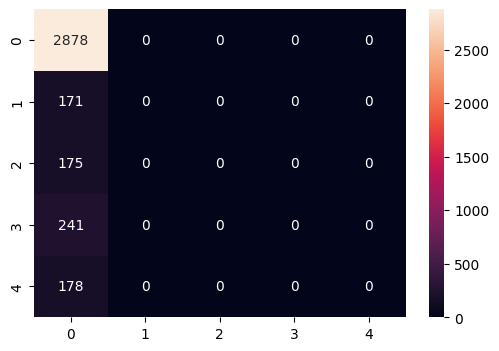

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Assuming you have 'y_test' and 'pred_no_nan' from your previous code

# Get the unique classes in y_test
classes = np.unique(y_test)

# Binarize the labels for each class
y_test_binarized = label_binarize(y_test, classes=classes)

# Calculate precision-recall curve for each class
for i, c in enumerate(classes):
    # If pred_no_nan has only one column, use it directly
    # Otherwise, select the appropriate column based on the class index
    if pred_no_nan.ndim > 1 and pred_no_nan.shape[1] > i:
        target_predictions = pred_no_nan[:, i]
    else:
        target_predictions = pred_no_nan.ravel()  # Use ravel to flatten if single column

    precision, recall, thresholds = precision_recall_curve(
        y_test_binarized[:, i], target_predictions
    )

    # Now you can use 'precision', 'recall', and 'thresholds' for class 'c'
    print(f"Precision-Recall Curve for Class {c}:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Thresholds: {thresholds}")

    # You can further plot the curves or calculate other metrics for each class

Precision-Recall Curve for Class 0.0:
Precision: [0.79000823 1.        ]
Recall: [1. 0.]
Thresholds: [0.]
Precision-Recall Curve for Class 1.0:
Precision: [0.04693934 1.        ]
Recall: [1. 0.]
Thresholds: [0.]
Precision-Recall Curve for Class 2.0:
Precision: [0.04803733 1.        ]
Recall: [1. 0.]
Thresholds: [0.]
Precision-Recall Curve for Class 3.0:
Precision: [0.06615427 1.        ]
Recall: [1. 0.]
Thresholds: [0.]
Precision-Recall Curve for Class 4.0:
Precision: [0.04886083 1.        ]
Recall: [1. 0.]
Thresholds: [0.]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Assuming you have 'y_test' and 'pred_no_nan' from your previous code

# Get the unique classes in y_test
classes = np.unique(y_test)

# Binarize the labels for each class
y_test_binarized = label_binarize(y_test, classes=classes)

# Calculate precision-recall curve for each class
precision = dict()
recall = dict()
thresholds = dict()
for i, c in enumerate(classes):
    # If pred_no_nan has only one column, use it directly
    # Otherwise, select the appropriate column based on the class index
    # If pred_no_nan has only one column, use it directly
    # Otherwise, select the appropriate column based on the class index
    if pred_no_nan.ndim > 1 and pred_no_nan.shape[1] > 1:  # Check for multi-column predictions
        target_predictions = pred_no_nan[:, i]
    else:
        target_predictions = pred_no_nan.ravel()  # Use ravel to flatten if single column

    precision[i], recall[i], thresholds[i] = precision_recall_curve(
        y_test_binarized[:, i], target_predictions
    )

    # Now you can use 'precision[i]', 'recall[i]', and 'thresholds[i]' for class 'c'
    print(f"Precision-Recall Curve for Class {c}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"Thresholds: {thresholds[i]}")

    # You can further plot the curves or calculate other metrics for each class

# To calculate differences in thresholds, access the specific class's thresholds:
# Check the shape and size of thresholds before accessing elements
if thresholds[0].shape[0] > 1:  # Access thresholds for class 0, for example
    # If there are multiple thresholds, calculate differences
    diff1 = thresholds[0][1] - thresholds[0][0]
    diff2 = thresholds[0][2] - thresholds[0][1]
    diff3 = thresholds[0][3] - thresholds[0][2]
    print(diff1, diff2, diff3)  # Print the differences
else:
    # If there is only one threshold, print a message
    print("Thresholds array has only one element. Cannot calculate differences.")

Precision-Recall Curve for Class 0.0:
Precision: [0.79000823 1.        ]
Recall: [1. 0.]
Thresholds: [0.]
Precision-Recall Curve for Class 1.0:
Precision: [0.04693934 1.        ]
Recall: [1. 0.]
Thresholds: [0.]
Precision-Recall Curve for Class 2.0:
Precision: [0.04803733 1.        ]
Recall: [1. 0.]
Thresholds: [0.]
Precision-Recall Curve for Class 3.0:
Precision: [0.06615427 1.        ]
Recall: [1. 0.]
Thresholds: [0.]
Precision-Recall Curve for Class 4.0:
Precision: [0.04886083 1.        ]
Recall: [1. 0.]
Thresholds: [0.]
Thresholds array has only one element. Cannot calculate differences.


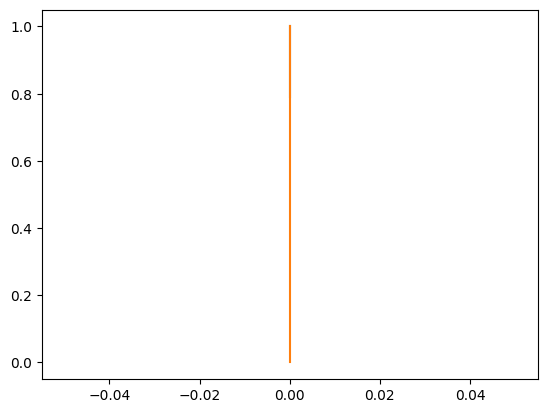

In [ ]:
import matplotlib.pyplot as plt

# Assuming you want to plot for class 0, for example
class_index = 0

plt.plot([0] + list(thresholds[class_index]), precision[class_index])
plt.plot([0] + list(thresholds[class_index]), recall[class_index])
plt.show()

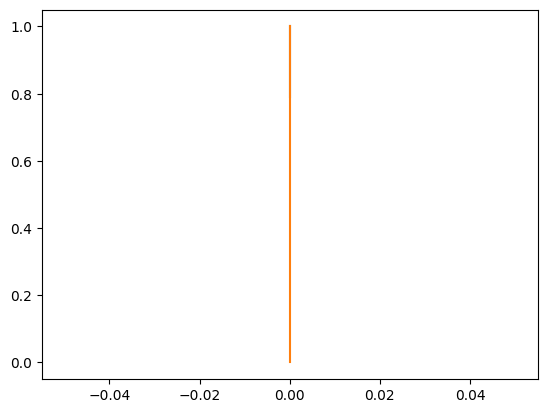

In [ ]:
# Accessing data for class 0, for example
plt.plot([0] + list(thresholds[0]), precision[0])
plt.plot([0] + list(thresholds[0]), recall[0])
plt.show()

### Balancing the data (2 classes)

In [ ]:
# df

In [ ]:
y.value_counts()

,count
Label,
0.0,1400
3.0,800
2.0,600
4.0,600
1.0,598


In [ ]:
g = df.groupby('Label')
balanced_df = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))

<ipython-input-66-a575cc3f406e>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))


In [ ]:
y = balanced_df['Label']
y

Label     
0.0    0      0.0
       1      0.0
       2      0.0
       3      0.0
       4      0.0
             ... 
4.0    593    4.0
       594    4.0
       595    4.0
       596    4.0
       597    4.0
Name: Label, Length: 2990, dtype: float64

In [ ]:
X = balanced_df.drop('Label', axis=1)
X

0      1      2      3       4       5       6       7       8    \
Label                                                                           
0.0   0    1.000  0.901  0.538  0.236  0.1790  0.1770  0.1200  0.1140  0.1200   
      1    0.983  0.832  0.297  0.000  0.1510  0.2450  0.2620  0.2980  0.3040   
      2    1.000  0.935  0.732  0.268  0.1320  0.2080  0.1710  0.1060  0.1300   
      3    1.000  0.634  0.328  0.373  0.3130  0.3130  0.2990  0.3280  0.3060   
      4    1.000  0.985  0.542  0.121  0.0458  0.0771  0.0812  0.0875  0.0812   
...          ...    ...    ...    ...     ...     ...     ...     ...     ...   
4.0   593  0.827  0.503  0.509  0.512  0.4670  0.4640  0.3990  0.2890  0.1430   
      594  1.000  0.939  0.882  0.800  0.6950  0.5840  0.4650  0.3720  0.2850   
      595  0.897  0.522  0.558  0.594  0.6030  0.5940  0.5800  0.5180  0.3440   
      596  0.471  0.440  0.396  0.361  0.3270  0.2860  0.2480  0.1820  0.1330   
      597  0.679  0.612  0.504  0.325  0.1940  0.2130  0.1680  0.0821  0.0634   

              9    ...  177  178  179  180  181  182  183  184  185  186  
Label              ...                                                    
0.0   0    0.1200  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
      1    0.2980  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
      2    0.1120  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
      3    0.3280  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
      4    0.0688  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
4.0   593  0.0000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
      594  0.2100  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
      595  0.1790  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
      596  0.0332  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
      597  0.0709  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2990 rows x 187 columns]

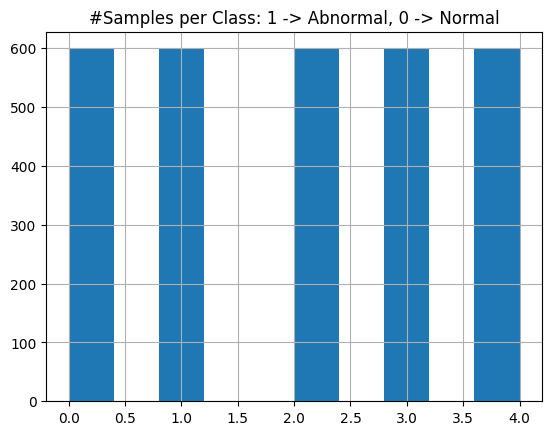

In [ ]:
y.hist()
plt.title('#Samples per Class: 1 -> Abnormal, 0 -> Normal')
plt.show()

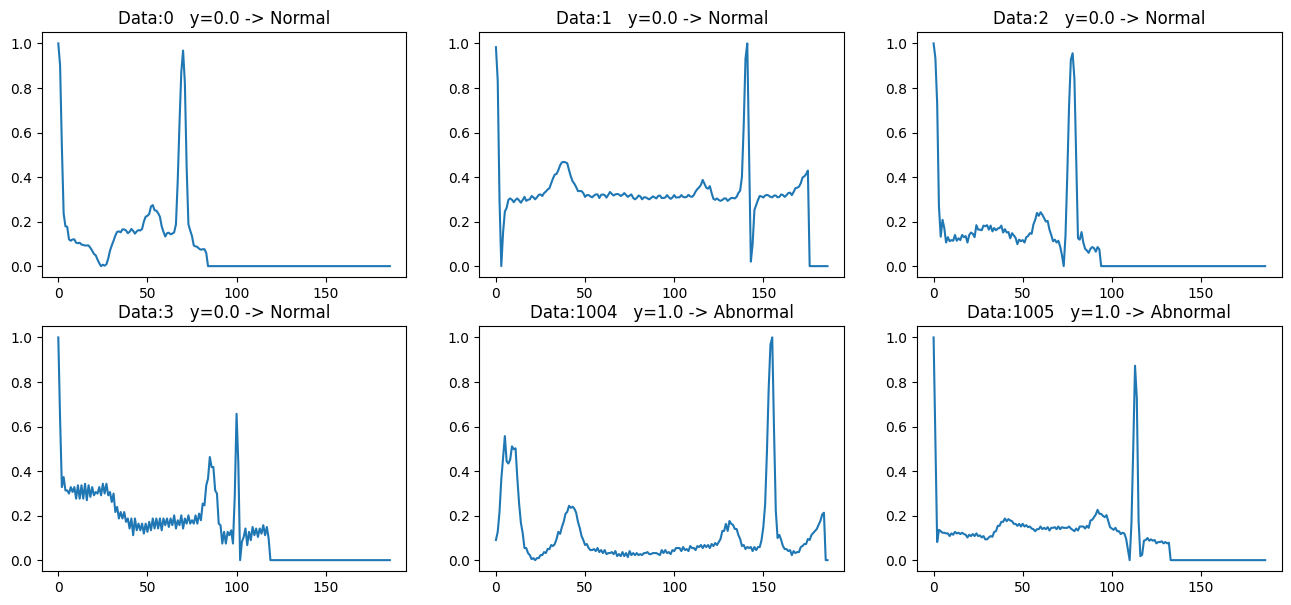

In [ ]:
n = 6
plt.figure(figsize=(16,7))
s=0 # Changed s to 0 to start from the beginning of the DataFrame
for i in range(n):
    if i>3:
        # Consider adjusting this logic if needed for a different subset of data
        s = 1000 # Changed s to a value within the bounds of the DataFrame
    plt.subplot(200+(n*5)+i+1)
    X.iloc[s+i].plot()
    t = 'Normal'
    if y.iloc[s+i]:
        t = 'Abnormal'
    plt.title(f'Data:{s+i}   y={y.iloc[s+i]} -> {t}')

plt.show()

In [ ]:
# Using only time domain data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2093, 187), (897, 187), (2093,), (897,))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',AUC(name='auc')])

In [ ]:
callbacks_list = [EarlyStopping(monitor='val_loss',
                                patience=20,
                                restore_best_weights=True)]

In [ ]:
model_history = model.fit(X_train,
                          y_train,
                          validation_split=0.2,
                          batch_size=128,
                          epochs=100,
                          callbacks=callbacks_list)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 980ms/step - accuracy: 0.1939 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.1671 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 925ms/step - accuracy: 0.1870 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.1671 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 928ms/step - accuracy: 0.1900 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.1671 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 896ms/step - accuracy: 0.2167 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.1671 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 926ms/step - accuracy: 0.1976 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.1671 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 898ms/step - accuracy: 0.1950 - auc: 0.0000e+00 - loss: nan - val_accuracy: 0.1671 - val_auc: 0.0000e+00 - val_loss: nan
Epoch 7/100
14/1

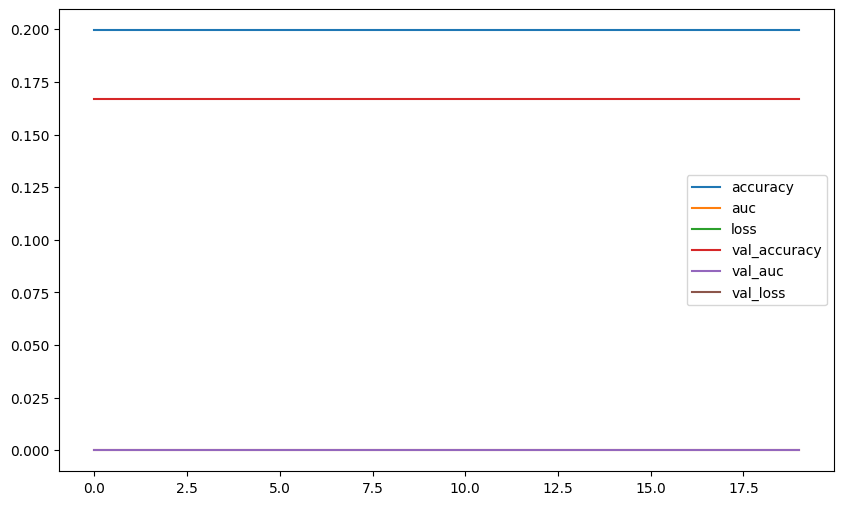

In [ ]:
plt.figure(figsize=[10,6])
for key in model_history.history.keys():
    plt.plot(model_history.history[key], label=key)

plt.legend()
plt.show()

In [ ]:
results = model.evaluate(X_test, y_test, verbose=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.2242 - auc: 0.0000e+00 - loss: nan


In [ ]:
print("         Loss: {:.2f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("     Test AUC: {:.4f}".format(results[2]))

         Loss: nan
Test Accuracy: 21.63%
     Test AUC: 0.0000


In [ ]:
pred = model.predict(X_test)
pred

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step


array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
      

In [ ]:
pred_05 = (pred > 0.5)
pred_05

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, pred_05)
print('      Class : [     0         1     ]')
print('  precision : {}'.format(precision))
print('     recall : {}'.format(recall))
print('     fscore : {}'.format(fscore))
print('    support : {}'.format(support))

      Class : [     0         1     ]
  precision : [0.21627648 0.         0.         0.         0.        ]
     recall : [1. 0. 0. 0. 0.]
     fscore : [0.35563703 0.         0.         0.         0.        ]
    support : [194 175 178 168 182]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!pip install numpy

import numpy as np
from sklearn.metrics import average_precision_score, accuracy_score, f1_score, confusion_matrix

# Replace NaN values in 'pred' with a suitable value, e.g., 0.
pred = np.nan_to_num(pred, nan=0.0) # Replace NaNs in 'pred' with 0

acc = accuracy_score(y_test, pred_05)
ap = average_precision_score(y_test, pred)
f1 = f1_score(y_test, pred_05, average=None, labels=[0,1])
cm = confusion_matrix(y_test, pred_05)

In [ ]:
print("        Accuracy: {:.2f}%".format(acc*100))
print("  Avg. precision: {0:0.4f}".format(ap))
print("                :[0,           1]")
print("        F1 Score:{}".format(f1))
print("Confusion Matrix:\n{}".format(cm))

        Accuracy: 21.63%
  Avg. precision: 0.2163
                :[0,           1]
        F1 Score:[0.35563703 0.        ]
Confusion Matrix:
[[194   0   0   0   0]
 [175   0   0   0   0]
 [178   0   0   0   0]
 [168   0   0   0   0]
 [182   0   0   0   0]]


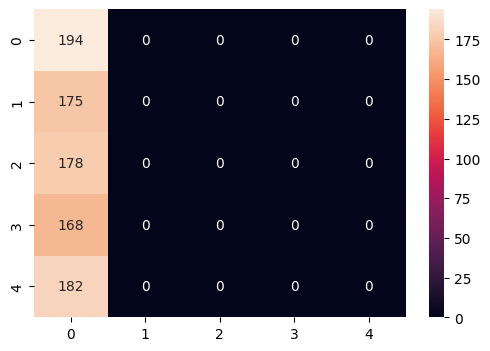

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

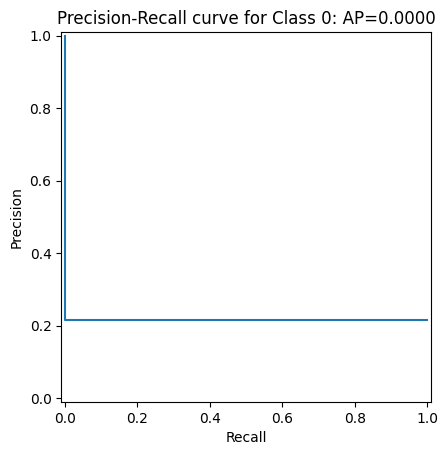

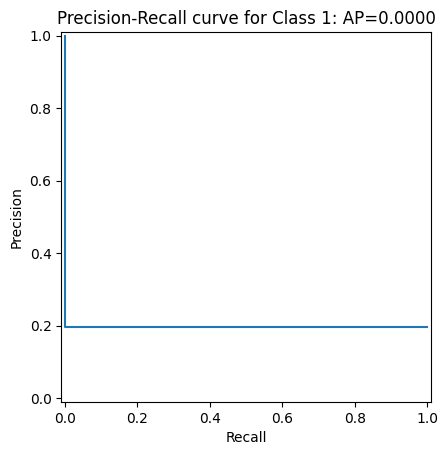

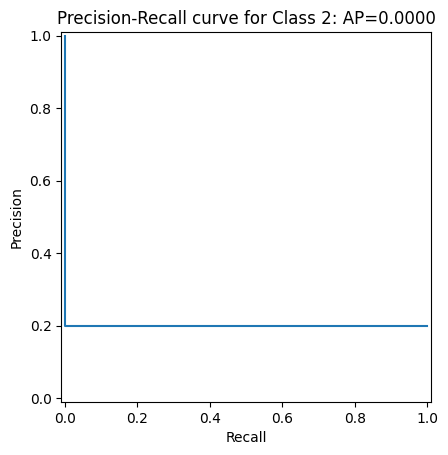

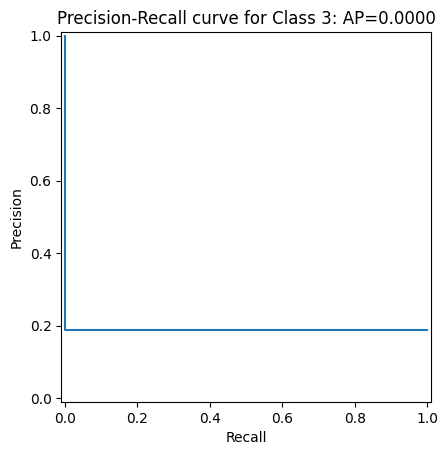

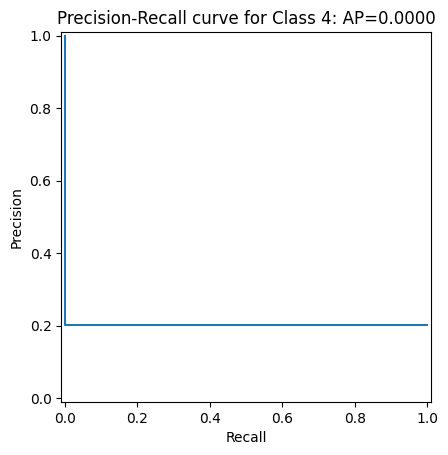

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming 'y_test' is your true labels and 'pred' your predictions

# If 'pred' contains probabilities for a single class, use it directly:
# No need to slice pred[:, i] in this case

# Binarize the labels if necessary
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
# If y_test is already binary, this step is redundant but won't cause harm

# For multi-class scenario, iterate through classes:
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    # Use pred directly instead of pred[:, i] as it's already 1-dimensional
    precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], pred.ravel())
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(f'Precision-Recall curve for Class {i}: AP={0:0.4f}'.format(ap))
    plt.show()

### Save Model

In [ ]:
model.save('ECG_PTB.h5')

## Multi-class Classification into five classes from MIT-BIH dataset
to be continued...

In [ ]:
df_list = [pd.read_csv('/content/mit-bih_train.csv') for i in ['train','test']]
for i,df in enumerate(df_list):
    df.columns = list(range(len(df.columns)))
    df_list[i] = df.rename({187:'Label'}, axis=1)

In [ ]:
import pandas as pd
import os

# Get the current directory
current_directory = os.getcwd()

# Define file paths relative to the current directory
file_paths = [os.path.join(current_directory, 'mitbih_'+i+'.csv') for i in ['train','test']]

# Read the files into a list of DataFrames
df_list = [pd.read_csv('/content/mit-bih_train.csv') for file_path in file_paths]

for i,df in enumerate(df_list):
    df.columns = list(range(len(df.columns)))
    df_list[i] = df.rename({187:'Label'}, axis=1)

In [ ]:
# Train
df_list[0]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,Label
0,0.960,0.863,0.462,0.1970,0.0940,0.1250,0.0997,0.0883,0.0741,0.0826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000,0.659,0.186,0.0703,0.0703,0.0595,0.0568,0.0432,0.0541,0.0459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925,0.666,0.541,0.2760,0.1960,0.0773,0.0718,0.0608,0.0663,0.0580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967,1.000,0.831,0.5870,0.3570,0.2490,0.1460,0.0892,0.1170,0.1500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927,1.000,0.627,0.1930,0.0950,0.0725,0.0432,0.0535,0.0933,0.1900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Test
df_list[1]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,Label
0,0.960,0.863,0.462,0.1970,0.0940,0.1250,0.0997,0.0883,0.0741,0.0826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000,0.659,0.186,0.0703,0.0703,0.0595,0.0568,0.0432,0.0541,0.0459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925,0.666,0.541,0.2760,0.1960,0.0773,0.0718,0.0608,0.0663,0.0580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967,1.000,0.831,0.5870,0.3570,0.2490,0.1460,0.0892,0.1170,0.1500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927,1.000,0.627,0.1930,0.0950,0.0725,0.0432,0.0535,0.0933,0.1900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Let's concat them
df = pd.concat(df_list, axis=0).reset_index(drop=True)
df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,Label
0,0.960,0.863,0.462,0.1970,0.0940,0.1250,0.0997,0.0883,0.0741,0.0826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000,0.659,0.186,0.0703,0.0703,0.0595,0.0568,0.0432,0.0541,0.0459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925,0.666,0.541,0.2760,0.1960,0.0773,0.0718,0.0608,0.0663,0.0580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967,1.000,0.831,0.5870,0.3570,0.2490,0.1460,0.0892,0.1170,0.1500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927,1.000,0.627,0.1930,0.0950,0.0725,0.0432,0.0535,0.0933,0.1900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df = pd.read_csv('../input/heartbeat/mitbih_train.csv')
# df.columns = list(range(len(df.columns)))
# df = df.rename({187:'Label'}, axis=1)

In [ ]:
y = df['Label']
y

,Label
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
12137,NaN
12138,NaN
12139,NaN
12140,NaN


In [ ]:
y.value_counts()

,count
Label,
0.0,1400
3.0,800
2.0,600
4.0,600
1.0,598


<Axes: >

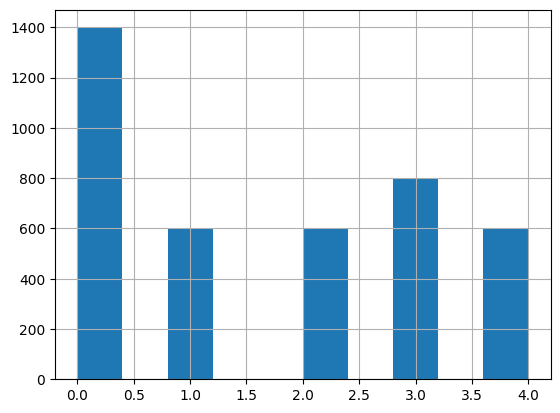

In [ ]:
y.hist()

In [ ]:
X = df.drop('Label', axis=1)
X

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.960,0.863,0.462,0.1970,0.0940,0.1250,0.0997,0.0883,0.0741,0.0826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000,0.659,0.186,0.0703,0.0703,0.0595,0.0568,0.0432,0.0541,0.0459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925,0.666,0.541,0.2760,0.1960,0.0773,0.0718,0.0608,0.0663,0.0580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967,1.000,0.831,0.5870,0.3570,0.2490,0.1460,0.0892,0.1170,0.1500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927,1.000,0.627,0.1930,0.0950,0.0725,0.0432,0.0535,0.0933,0.1900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


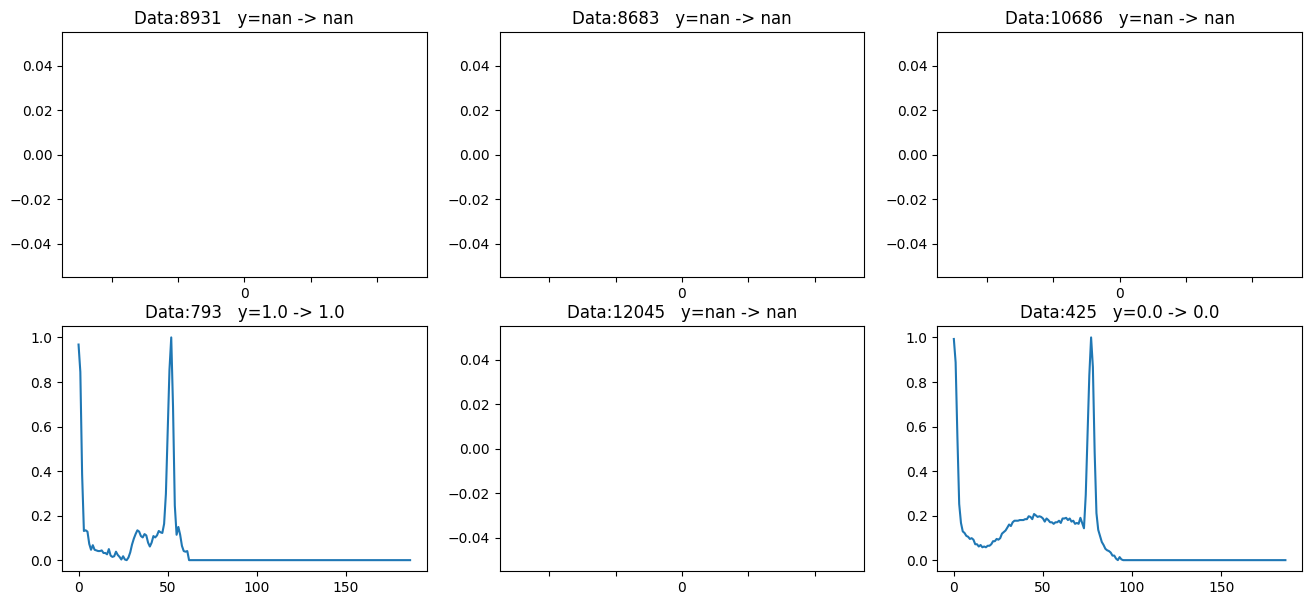

In [ ]:
import random
import matplotlib.pyplot as plt

n = 6
plt.figure(figsize=(16, 7))

for i in range(n):
    # Ensure the random index is within the bounds of the DataFrame
    s = random.randint(0, len(X) - 1)
    plt.subplot(200 + (n * 5) + i + 1)
    X.iloc[s].plot()  # Use s as the index directly
    plt.title(f'Data:{s}   y={y.iloc[s]} -> {y.iloc[s]}')

plt.show()

## Label Encoding y's

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical  # Import to_categorical directly

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical  # Import to_categorical directly

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
# Use to_categorical directly from tensorflow.keras.utils
dummy_y = to_categorical(encoded_y)

In [ ]:
dummy_y

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.3, random_state=42)

## Model

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8499, 187), (3643, 187), (8499, 6), (3643, 6))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',AUC(name='auc')])

In [ ]:
callbacks_list = [EarlyStopping(monitor='val_loss',
                                patience=20,
                                restore_best_weights=True)]

### Balancing the data (5 classes)

In [ ]:
from sklearn.utils import resample

In [ ]:
df_0 = df[df['Label']==0]
df_1 = df[df['Label']==1]
df_2 = df[df['Label']==2]
df_3 = df[df['Label']==3]
df_4 = df[df['Label']==4]

In [ ]:
def sampling_k_elements(group, k=8039):
    if len(group) <= k:
        return group
    return group.sample(k)

balanced_df = df.groupby('Label').apply(sampling_k_elements).reset_index(drop=True)

<ipython-input-113-79cef26650fd>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('Label').apply(sampling_k_elements).reset_index(drop=True)


In [ ]:
balanced_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,Label
0,0.960,0.863,0.462,0.1970,0.0940,0.1250,0.0997,0.0883,0.0741,0.0826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000,0.659,0.186,0.0703,0.0703,0.0595,0.0568,0.0432,0.0541,0.0459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925,0.666,0.541,0.2760,0.1960,0.0773,0.0718,0.0608,0.0663,0.0580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967,1.000,0.831,0.5870,0.3570,0.2490,0.1460,0.0892,0.1170,0.1500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927,1.000,0.627,0.1930,0.0950,0.0725,0.0432,0.0535,0.0933,0.1900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3993,0.616,0.455,0.428,0.4190,0.4020,0.3720,0.3550,0.3050,0.2260,0.1200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3994,0.706,0.621,0.512,0.4100,0.2760,0.1580,0.0782,0.0353,0.0000,0.0184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3995,0.876,0.823,0.758,0.6950,0.6050,0.4970,0.3750,0.2340,0.1290,0.0868,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3996,0.772,0.514,0.514,0.5380,0.5140,0.5030,0.4620,0.4030,0.2660,0.1660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
y = balanced_df['Label']
y

,Label
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
3993,4.0
3994,4.0
3995,4.0
3996,4.0


In [ ]:
y.value_counts()

,count
Label,
0.0,1400
3.0,800
2.0,600
4.0,600
1.0,598


<Axes: >

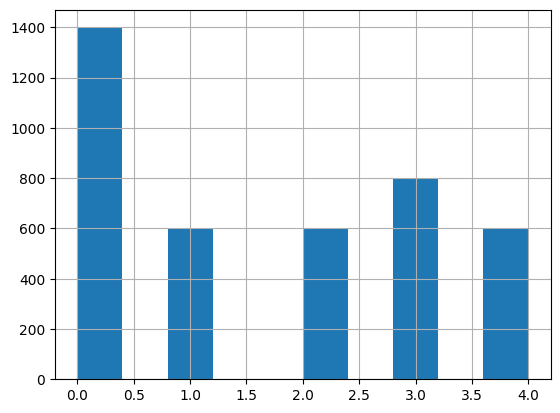

In [ ]:
y.hist()

In [ ]:
X = balanced_df.drop('Label', axis=1)
X

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.960,0.863,0.462,0.1970,0.0940,0.1250,0.0997,0.0883,0.0741,0.0826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000,0.659,0.186,0.0703,0.0703,0.0595,0.0568,0.0432,0.0541,0.0459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925,0.666,0.541,0.2760,0.1960,0.0773,0.0718,0.0608,0.0663,0.0580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967,1.000,0.831,0.5870,0.3570,0.2490,0.1460,0.0892,0.1170,0.1500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927,1.000,0.627,0.1930,0.0950,0.0725,0.0432,0.0535,0.0933,0.1900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3993,0.616,0.455,0.428,0.4190,0.4020,0.3720,0.3550,0.3050,0.2260,0.1200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3994,0.706,0.621,0.512,0.4100,0.2760,0.1580,0.0782,0.0353,0.0000,0.0184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3995,0.876,0.823,0.758,0.6950,0.6050,0.4970,0.3750,0.2340,0.1290,0.0868,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3996,0.772,0.514,0.514,0.5380,0.5140,0.5030,0.4620,0.4030,0.2660,0.1660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


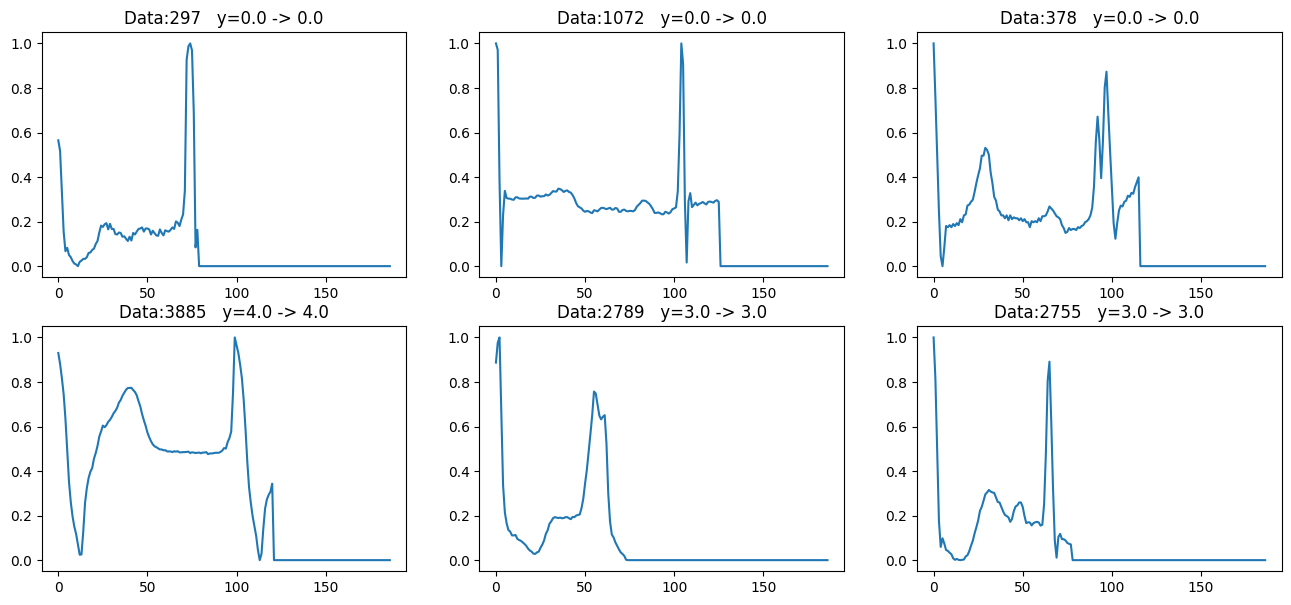

In [ ]:
import random
import matplotlib.pyplot as plt

n = 6
plt.figure(figsize=(16,7))

for i in range(n):
    # Ensure the random index is within the bounds of the DataFrame
    s = random.randint(0, len(X) - n)  # Subtract n to prevent going out of bounds
    plt.subplot(200+(n*5)+i+1)
    X.iloc[s+i].plot()
    # t = 'Normal'
    # if y.iloc[s+i]:
    #     t = 'Abnormal'
    plt.title(f'Data:{s+i}   y={y.iloc[s+i]} -> {y.iloc[s+i]}')

plt.show()

## Label Encoding y's

In [ ]:
from sklearn.preprocessing import LabelEncoder
# from keras.utils import np_utils # np_utils is no longer part of keras.utils. Use tensorflow.keras.utils.to_categorical instead
from tensorflow.keras.utils import to_categorical # Import to_categorical directly from tensorflow.keras.utils

# Assuming 'y' is your target variable and you want to one-hot encode it:
# encoded_y = np_utils.to_categorical(y) # Replace this with the following:
encoded_y = to_categorical(y)

In [ ]:
from sklearn.preprocessing import LabelEncoder
# from keras.utils import np_utils  # np_utils is deprecated, use to_categorical directly
from tensorflow.keras.utils import to_categorical # Import to_categorical

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_y) # Use to_categorical directly

In [ ]:
dummy_y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.3, random_state=42)

## Model

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2798, 187), (1200, 187), (2798, 5), (1200, 5))

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Activation, Conv1D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.backend import expand_dims

# ... (rest of your imports and code)

inputs = Input(shape=(X_train.shape[1],))
# Use Reshape instead of expand_dims
# expand = expand_dims(inputs, axis=2)  # Incorrect
expand = Reshape((X_train.shape[1], 1))(inputs) # Correct

# Adding Conv1D
conv1 = Conv1D(filters=128,kernel_size=5,strides=1)(expand)
conv1 = Activation("relu")(conv1)
conv2 = Conv1D(filters=256,kernel_size=5,strides=2)(conv1)
conv2 = Activation("relu")(conv2)
lstm = LSTM(100,return_sequences=True)(conv2)
lstm = LSTM(100,return_sequences=True)(lstm)
flatten = Flatten()(lstm)
outputs = Dense(5, activation='softmax')(flatten)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 187)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 183, 128)            │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 183, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 90, 256)             │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 90, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 90, 100)             │         142,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 90, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │          45,005 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 433,069 (1.65 MB)

 Trainable params: 433,069 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',AUC(name='auc')])

In [ ]:
callbacks_list = [EarlyStopping(monitor='val_loss',
                                patience=20,
                                restore_best_weights=True)]

In [ ]:
model_history = model.fit(X_train,
                          y_train,
                          validation_split=0.2,
                          batch_size=128,
                          epochs=100,
                          callbacks=callbacks_list)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 896ms/step - accuracy: 0.3262 - auc: 0.6536 - loss: 1.4999 - val_accuracy: 0.4607 - val_auc: 0.7989 - val_loss: 1.2446
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 887ms/step - accuracy: 0.5553 - auc: 0.8492 - loss: 1.1169 - val_accuracy: 0.6250 - val_auc: 0.8893 - val_loss: 0.9453
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 892ms/step - accuracy: 0.6421 - auc: 0.8829 - loss: 0.9647 - val_accuracy: 0.6768 - val_auc: 0.8993 - val_loss: 0.8973
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 911ms/step - accuracy: 0.6878 - auc: 0.9033 - loss: 0.8763 - val_accuracy: 0.6911 - val_auc: 0.9153 - val_loss: 0.8167
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7326 - auc: 0.9323 - loss: 0.7325 - val_accuracy: 0.7196 - val_auc: 0.9289 - val_loss: 0.7458
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 888ms/step - accuracy: 0.7808 - auc: 0.9449 - loss: 0.6553 - val_accuracy: 0.7839 - val_auc: 0.9490 - val_loss: 0.6307
Epoch 7/100
18/18 ━━━━━━━━━━━━━

In [ ]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

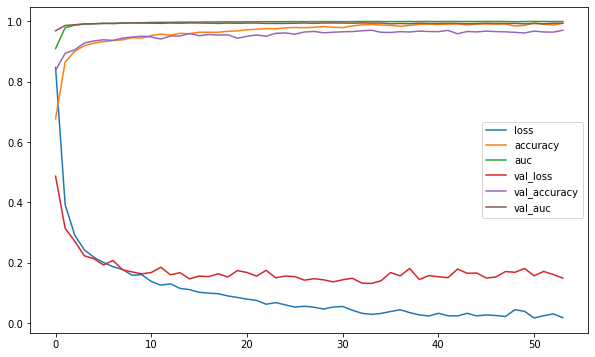

In [ ]:
plt.figure(figsize=[10,6])
for key in model_history.history.keys():
    plt.plot(model_history.history[key], label=key)

plt.legend()
plt.show()

In [ ]:
results = model.evaluate(X_test, y_test, verbose=1)

253/253 [==============================] - 2s 7ms/step - loss: 0.1598 - accuracy: 0.9633 - auc: 0.9932


In [ ]:
print("         Loss: {:.2f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("     Test AUC: {:.4f}".format(results[2]))

         Loss: 0.16
Test Accuracy: 96.33%
     Test AUC: 0.9932


In [ ]:
pred = model.predict(X_test)
pred

array([[5.4806546e-09, 1.5795931e-10, 7.1111966e-10, 3.2282367e-15,
        1.0000000e+00],
       [6.3951524e-17, 1.0860080e-14, 4.4637401e-11, 1.0939337e-20,
        1.0000000e+00],
       [4.5287292e-02, 5.8262849e-06, 2.5220706e-06, 9.5470381e-01,
        6.0135102e-07],
       ...,
       [8.0560955e-07, 5.6245899e-06, 9.9999249e-01, 4.8504656e-08,
        1.0506849e-06],
       [7.9434058e-06, 9.8150565e-08, 2.1364571e-08, 4.5240051e-10,
        9.9999189e-01],
       [5.7586047e-05, 4.5629522e-09, 1.1691757e-08, 2.8027039e-10,
        9.9994242e-01]], dtype=float32)

In [ ]:
pred = np.argmax(pred, axis=1)
pred

array([4, 4, 3, ..., 2, 4, 4])

In [ ]:
np.argmax(y_test, axis=1)

array([4, 4, 0, ..., 2, 4, 4])

In [ ]:
acc = accuracy_score(np.argmax(y_test, axis=1), pred)
f1 = f1_score(np.argmax(y_test, axis=1), pred,average=None, labels=[0,1,2,3,4])
cm = confusion_matrix(np.argmax(y_test, axis=1), pred)

In [ ]:
print("        Accuracy: {:.2f}%".format(acc*100))
print("                :[0,           1         2           3         4]")
print("        F1 Score:{}".format(f1))
print("Confusion Matrix:\n{}".format(cm))

        Accuracy: 96.33%
                :[0,           1         2           3         4]
        F1 Score:[0.95634182 0.91557669 0.97126969 0.81990521 0.99201638]
Confusion Matrix:
[[2311   50   21    6    3]
 [  64  770   12    0    8]
 [  26    8 2096   13    6]
 [  28    0   29  173    0]
 [  13    0    9    0 2423]]


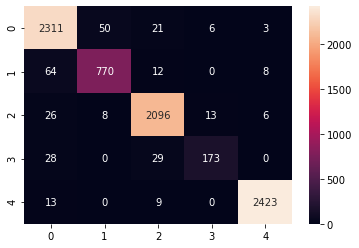

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

### Balancing the data (5 classes)

## Save Model